In [1]:
import pandas as pd
import json
%matplotlib inline

with open("../generated/plain_prov/floydwarshall.json", "r") as f:
    prov = json.load(f)
with open("../generated/prov_dictionary/floydwarshall.json", "r") as f:
    prov_dictionary = json.load(f)
with open("../generated/mutable_prov/floydwarshall.json", "r") as f:
    mutable_prov = json.load(f)
with open("../generated/intertwined_prov/floydwarshall.json", "r") as f:
    intertwined_prov = json.load(f)
with open("../generated/versioned_prov/floydwarshall.json", "r") as f:
    versioned_prov = json.load(f)

In [2]:
order = [
    'approach',
    'entity', 'activity', 'value', 
    'used', 'wasDerivedFrom', 'wasGeneratedBy', 'specializationOf',
    'hadMember', 'hadDictionaryMember', 'derivedByInsertionFrom',
    'accessedPart', 'accessed', 'defined', 'wasDefinedBy', 'derivedByInsertion',
]
nodes = ['entity', 'activity', 'value']
relationships = [x for x in order if x not in nodes and x != "approach"]

In [3]:
df = pd.DataFrame([
    dict(**{'approach': 'PROV'}, **dict(prov["all"]["global"])),
    dict(**{'approach': 'PROV-Dictionary'}, **dict(prov_dictionary["all"]["global"])),
    dict(**{'approach': 'Mutable-PROV'}, **dict(mutable_prov["all"]["global"])),
    dict(**{'approach': 'Intertwined-PROV'}, **dict(intertwined_prov["all"]["global"])),
    dict(**{'approach': 'Versioned-PROV'}, **dict(versioned_prov["all"]["global"])),

], columns=order)

df[order[1:]] = df[order[1:]].fillna(0.0).astype(int)
df

,approach,entity,activity,value,used,wasDerivedFrom,wasGeneratedBy,specializationOf,hadMember,hadDictionaryMember,derivedByInsertionFrom,accessedPart,accessed,defined,wasDefinedBy,derivedByInsertion
0,PROV,123,94,0,97,125,10,0,117,0,0,0,0,0,0,0
1,PROV-Dictionary,124,94,0,97,105,10,0,0,0,39,0,0,0,0,0
2,Mutable-PROV,98,92,20,94,36,61,0,0,0,0,59,24,15,15,8
3,Intertwined-PROV,177,137,0,154,146,2,29,0,15,3,0,0,0,0,0
4,Versioned-PROV,103,92,0,103,95,5,0,18,0,0,0,0,0,0,0


In [4]:
df = df.drop([
    'value', 'accessed', 'accessedPart', 'defined', 
    'wasDefinedBy', 'derivedByInsertion', 'hadDictionaryMember', 
    'specializationOf'
], axis=1).drop([2, 3])
df

,approach,entity,activity,used,wasDerivedFrom,wasGeneratedBy,hadMember,derivedByInsertionFrom
0,PROV,123,94,97,125,10,117,0
1,PROV-Dictionary,124,94,97,105,10,0,39
4,Versioned-PROV,103,92,103,95,5,18,0


In [5]:
fmt = ['---' for i in range(len(df.columns))]
df_fmt = pd.DataFrame([fmt], columns=df.columns)
df_formatted = pd.concat([df_fmt, df])
df_formatted.columns = [
    'Approach',
    'entity', 'activity',
    #'value', 
    'used', 'was<br>Derived<br>From', 'was<br>Generated<br>By',
    #'specialization<br>Of',
    'had<br>Member', 
    #'had<br>Dictionary<br>Member',
    'derived<br>By<br>Insertion<br>From',
    #'accessed<br>Part', 'accessed', 'defined', 'was<br>Defined<br>By', 'derived<br>By<br>Insertion',
]
with open("../generated/table.md", "w") as f:
    f.write(df_formatted.to_csv(sep="|", index=False))

In [6]:
df['nodes'] = sum(df[x] for x in nodes if x in df.columns)
df['edges'] = sum(df[x] for x in relationships if x in df.columns)

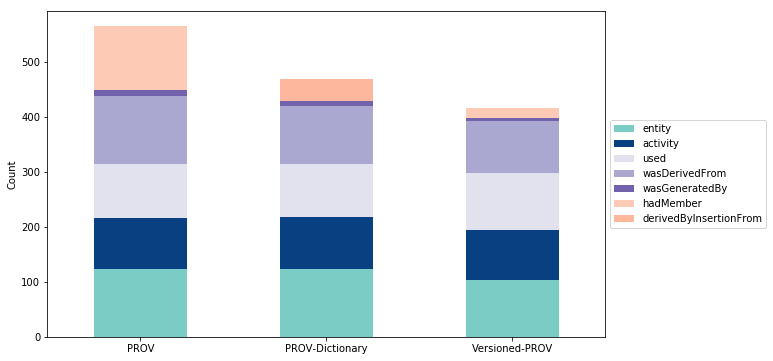

In [7]:
import matplotlib.pyplot as plt
import numpy as np

parts = len(order) - 1

colors1 = plt.cm.GnBu(np.linspace(0.5, 1, 2))
colors2 = plt.cm.Purples(np.linspace(0.2, 0.7, 3))
colors3 = plt.cm.Reds(np.linspace(0.2, 0.7, parts - 3 - 3))


# combine them and build a new colormap
colors = np.vstack((colors1, colors2, colors3))
#colors = plt.cm.GnBu(np.linspace(0, 1, 3))


gdf = df.set_index(["approach"])[df.columns[1:-2]]
f = plt.figure()
ax = f.gca()
gdf.plot(kind='bar', stacked=True, ax=ax, color=colors)
lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
f.set_size_inches(10, 6)
plt.savefig("../generated/graphs/comparison.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../generated/graphs/comparison.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../generated/graphs/comparison.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


## Approach Based - Analysis

In [8]:
gdf = (
    df.set_index(["approach"])
    #.drop(['Mutable-PROV', 'Intertwined-PROV'])
    .rename(index={
        "PROV": "Plain",
        "PROV-Dictionary": "Dict",
        "Versioned-PROV": "Ver",
        "Mutable-PROV": "M",
        "Intertwined-PROV": "I",
    })
)

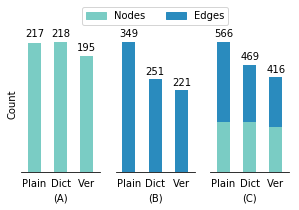

In [9]:
from collections import Counter
import matplotlib.patches as mpatches
def annotate(ax):
    w2 = ax.containers[0].get_children()[0].get_width() / 2.0
    c = Counter()
    for p in ax.patches:
        c[p.get_x()] += int(p.get_height())
    
    for key, value in c.items():
        ax.text(
            key + w2, value * 1.05, str(value), ha='center'
        )
    ax.yaxis.set_ticklabels([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
        
colors = plt.cm.GnBu(np.linspace(0.5, 1, 3))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)

gdf["nodes"].plot(kind='bar', color=colors[0], ax=ax1, rot=0)
ax1.set_xlabel("(A)")
ax1.set_ylabel("Count")
annotate(ax1)

gdf["edges"].plot(kind='bar', color=colors[1], ax=ax2, rot=0)
ax2.set_xlabel("(B)")
ax2.set_ylabel("")
annotate(ax2)

sdf = gdf[["nodes", "edges"]]
sdf.plot(kind='bar', stacked=True, ax=ax3, color=colors)
ax3.set_xlabel("(C)")
ax3.set_ylabel("")
ax3.legend().set_visible(False)
annotate(ax3)


lnodes = mpatches.Patch(color=colors[0], label='Nodes')
lrelationships = mpatches.Patch(color=colors[1], label='Edges')


#handles, labels = ax3.get_legend_handles_labels()
lgd = ax2.legend(
    handles=[lnodes, lrelationships],
    loc='center', ncol=2,
    bbox_to_anchor=(0.5, 1.15))


plt.xticks(rotation=0)
f.set_size_inches(4.8, 2.5)
plt.savefig("../generated/graphs/paper_comparison.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../generated/graphs/paper_comparison.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../generated/graphs/paper_comparison.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')